# AllTissueAllSplicingJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
#install.packages('R.utils')
library(R.utils)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

## Analysis 

This analysis uses edgeR.  Normalization takes the form of correction factors computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

In this analysis, we are using the raw counts as provided by rMATS 3.2.5.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.


Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

### Did you remember?
Did you remember to delete your private github token?  Now is a good time to do so, before you save your work and checkit in inadvertantly....

In [2]:
if (!("rmats_final.se.jc.ijc.txt.gz" %in% list.files("../significant_events/"))) {    
    # SE
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    # RI
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    # MXE
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    # A3SS
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
     # A5SS
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../rmats_counts/")
} 

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to-date already

Warning message in get_token():
“Using default public GITHUB_TOKEN.
                     Please set your own token”All files up-to

## Read in the count data

In [3]:
message("loading a3ss.jc.ijc rMATS 3.2.5 counts\n")
a3ss.jc.ijc <- data.table::fread("../rmats_counts/rmats_final.a3ss.jc.ijc.txt.gz")
message("done!\n")
message("loading a3ss.jc.sjc rMATS 3.2.5 counts\n")
a3ss.jc.sjc <- data.table::fread("../rmats_counts/rmats_final.a3ss.jc.sjc.txt.gz")    
message("done!\n")

message("loading a5ss.jc.ijc rMATS 3.2.5 counts\n")
a5ss.jc.ijc <- data.table::fread("../rmats_counts/rmats_final.a5ss.jc.ijc.txt.gz")    
message("done!\n")
message("loading a5ss.jc.sjc rMATS 3.2.5 counts\n")
a5ss.jc.sjc <- data.table::fread("../rmats_counts/rmats_final.a5ss.jc.sjc.txt.gz")    
message("done!\n")

message("loading mxe.jc.ijc rMATS 3.2.5 counts\n")
mxe.jc.ijc  <- data.table::fread("../rmats_counts/rmats_final.mxe.jc.ijc.txt.gz")    
message("done!\n")
message("loading mxe.jc.sjc rMATS 3.2.5 counts\n")
mxe.jc.sjc  <- data.table::fread("../rmats_counts/rmats_final.mxe.jc.sjc.txt.gz")    
message("done!\n")

message("loading ri.jc.ijc rMATS 3.2.5 counts\n")
ri.jc.ijc   <- data.table::fread("../rmats_counts/rmats_final.ri.jc.ijc.txt.gz")    
message("done!\n")
message("loading ri.jc.sjc rMATS 3.2.5 counts\n")
ri.jc.sjc   <- data.table::fread("../rmats_counts/rmats_final.ri.jc.sjc.txt.gz")    
message("done!\n")

message("loading se.jc.ijc rMATS 3.2.5 counts\n")
se.jc.ijc   <- data.table::fread("../rmats_counts/rmats_final.se.jc.sjc.txt.gz")    
message("done!\n")
message("loading se.jc.sjc rMATS 3.2.5 counts\n")
se.jc.sjc   <- data.table::fread("../rmats_counts/rmats_final.se.jc.sjc.txt.gz")
message("done!\n")


loading a3ss.jc.ijc rMATS 3.2.5 counts

done!

loading a3ss.jc.sjc rMATS 3.2.5 counts

done!

loading a5ss.jc.ijc rMATS 3.2.5 counts

done!

loading a5ss.jc.sjc rMATS 3.2.5 counts

done!

loading mxe.jc.ijc rMATS 3.2.5 counts

done!

loading mxe.jc.sjc rMATS 3.2.5 counts

done!

loading ri.jc.ijc rMATS 3.2.5 counts

done!

loading ri.jc.sjc rMATS 3.2.5 counts

done!

loading se.jc.ijc rMATS 3.2.5 counts

done!

loading se.jc.sjc rMATS 3.2.5 counts

done!



## Read in metadata 

- `Sequence Read Archive (SRA)` Accession Data, `SRR` numbers
- `Genome Tissue Expression (GTEx)` Clinical Annotation

In [4]:
if (!("SraRunTable.txt.gz" %in% list.files("../data/"))) {
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "TheJacksonLaboratory/sbas", 
        file = "SraRunTable.txt.gz",
        tag  = "GTExV8.v1.0", 
        dest = "../data/")
    
    message("Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..\n")   
    metadata <- data.table::fread("../data/SraRunTable.txt.gz")
    message("done!")
} else {
    message("Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..\n")   
    metadata <- data.table::fread("../data/SraRunTable.txt.gz")
    message("done!\n")
}

if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading and loading obj with GTEx v8 with 'yarn::downloadGTExV8()'\n")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!\n")

} else {
# Load with readRDS() if gtex.rds available in data/
    message("Loading obj GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
} 
if (! (file.exists("../data/fromGTF.tar.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching fromGTF.tar.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.*.txt.gz into ../data")
    system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
    message("Done!\n")
    message("Reading fromGTF.SE.txt into fromGTF.SE")    
    fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
    message("Done!\n")
}

Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..

done!

Loading obj GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!

Generating sha256sum for gtex.rds ..

c3c81a2b5b1f17811d2ab828edf1d4c65e8e4a6632964db73555c4b5737fadf0  ../data/gtex.rds
Done!



## Read in junction Annotation Data

In [5]:
message("Reading fromGTF.A3SS.txt into fromGTF.A3SS")    
fromGTF.A3SS <- read.table("../data/fromGTF.A3SS.txt", header=TRUE)
message("Done!\n")

message("Reading fromGTF.A5SS.txt into fromGTF.A5SS")    
fromGTF.A5SS <- read.table("../data/fromGTF.A5SS.txt", header=TRUE)
message("Done!\n")

message("Reading fromGTF.MXE.txt into fromGTF.MXE")    
fromGTF.MXE <- read.table("../data/fromGTF.MXE.txt", header=TRUE)
message("Done!\n")

message("Reading fromGTF.RI.txt into fromGTF.RI")    
fromGTF.RI <- read.table("../data/fromGTF.RI.txt", header=TRUE)
message("Done!\n")

message("Reading fromGTF.SE.txt into fromGTF.SE")    
fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
message("Done!\n")


Reading fromGTF.A3SS.txt into fromGTF.A3SS
Done!

Reading fromGTF.A5SS.txt into fromGTF.A5SS
Done!

Reading fromGTF.MXE.txt into fromGTF.MXE
Done!

Reading fromGTF.RI.txt into fromGTF.RI
Done!

Reading fromGTF.SE.txt into fromGTF.SE
Done!



## Preparing our Data
### Aligning Annotations with Run Data and with Count Data

A description of the GTEx V8 release may be found here https://www.gtexportal.org/home/datasets.   To facilitate the analysis, the Quackenbush lab's Joe Paulson's Yarn Package, https://github.com/jnpaulson/yarn, forked and upgraded to GTEx V8 here https://github.com/TheJacksonLaboratory/yarn/tree/annes-changes.  

The sequences we used for our analysis with rMATS are specified by their SRR number and were obtained from dbGaP, with our application to the controlled access human data.  Beginning with these raw unfiltered fastq files, we ran them through the NextFlow workflow rmats-nf https://github.com/lifebit-ai/rmats-nf. The accession data was downloaded with a repository key from the google cloud bucket (g3).

- `obj`      : GTEx V8 expressionSet 
- `metadata` : SraRunTable.txt holds the SRR accession numbers used to extract samples from dbGaP SRA
- `ijc`      : inclusion junction counts as reported by `rMATS 3.2.5`
- `sjc`      : skipped junction counts as reported by `rMATS 3.2.5`  

For each of the splicing events:

- `a3ss`     : alternative 3` splice site
- `a5ss`     : alternative 5` splice site
- `mxe`      : mutually exclusive exon
- `ri`       : retention intron
- `se`       : skipped exon

In `rMATS 3.2.5`, each junction is encoded in a unique `ID` that is immutable regardless of comparison.  
This `ID` is different for each of the differing splicing events.

### Move Junction ID to Row definition

In [6]:
rownames(a3ss.jc.ijc) <- a3ss.jc.ijc$ID
rownames(a3ss.jc.sjc) <- a3ss.jc.sjc$ID
a3ss.jc.ijc <- a3ss.jc.ijc[,-1]
a3ss.jc.sjc <- a3ss.jc.sjc[,-1]

rownames(a5ss.jc.ijc) <- a3ss.jc.ijc$ID
rownames(a5ss.jc.sjc) <- a3ss.jc.sjc$ID
a5ss.jc.ijc <- a5ss.jc.ijc[,-1]
a5ss.jc.sjc <- a5ss.jc.sjc[,-1]

rownames(mxe.jc.ijc)  <- mxe.jc.ijc$ID
rownames(mxe.jc.sjc)  <- mxe.jc.sjc$ID
mxe.jc.ijc <- mxe.jc.ijc[,-1]
mxe.jc.sjc <- mxe.jc.sjc[,-1]

rownames(ri.jc.ijc)   <- ri.jc.ijc$ID
rownames(ri.jc.sjc)   <- ri.jc.sjc$ID
ri.jc.ijc <- ri.jc.ijc[,-1]
ri.jc.sjc <- ri.jc.sjc[,-1]

rownames(se.jc.ijc)   <- se.jc.ijc$ID
rownames(se.jc.sjc)   <- se.jc.sjc$ID
se.jc.ijc <- se.jc.ijc[,-1]
se.jc.sjc <- se.jc.sjc[,-1]

dim(a3ss.jc.ijc)
dim(a3ss.jc.sjc)
dim(a5ss.jc.ijc)
dim(a5ss.jc.sjc)
dim(mxe.jc.ijc)
dim(mxe.jc.sjc)
dim(ri.jc.ijc)
dim(ri.jc.sjc)
dim(se.jc.ijc)
dim(se.jc.sjc)


[1] 8920 8673

[1] 8920 8673

[1] 5584 8673

[1] 5584 8673

[1] 2979 8673

[1] 2979 8673

[1] 6312 8673

[1] 6312 8673

[1] 42611  8673

[1] 42611  8673

### Join Clinical Annotations and Accession Run 

Join the yarn metadata with the metadata we have (there are redundant samples that have been sequenced multiple times). We want to be sure that we can obtain all required Clinical Annotation information from the YARN GTEx Annotation information, as the SRA metadata is not as reliable.    This will be a one-to-many mapping, as there are multiple sequence runs per 69 samples -- expanding our data set.  There are only a handful of annotations we require: SEX, AGE, DTHHRDY (which is cause of death), SMCENTER.

Note that the numbers in specific age groups expand because of the one to many relationship from sample to sequencing runs.  

In [7]:
#Info before dplyr::left_join
table(pData(obj)$AGE)
table(pData(obj)$DTHHRDY)
table(pData(obj)$SMCENTER)
table(pData(obj)$SEX)
table(metadata$sex)
dim(pData(obj))
dim(metadata)
metadata$SAMPID   <- gsub('-','\\.',metadata$'Sample Name')
pData(obj)$SAMPID <- gsub('-','\\.',pData(obj)$SAMPID)

metadata_pData <- dplyr::left_join(metadata, pData(obj), by = "SAMPID")


20-29 30-39 40-49 50-59 60-69 70-79 
 1320  1323  2702  5615  5821   601 


   0    1    2    3    4 
8814  711 4839  868 2039 


        B1     B1, A1         C1     C1, A1 C1, B1, A1         D1     D1, A1 
     10635        971       4503       1076         22         88         77 


    1     2 
11584  5798 


       female   male 
    36   9130  15501 

[1] 17384    67

[1] 24667    79

###  Order metadata SRR run order in the same order as the ijc and sjc columns 

Rearrange the metadata order to match the count data sample order
and to reduce the sample by the same.   

In [8]:
# name the row names as the Run
rownames(metadata_pData) <- as.character(metadata_pData$Run)
head(rownames(metadata_pData))

SRR_accession_order  <- colnames(se.jc.ijc)
metadata_SRR_names   <- rownames(metadata_pData)

# first limit metadata to match only those Runs we have accessions for
SRR_in_metadata  <- metadata_SRR_names %in% SRR_accession_order

table(SRR_in_metadata)

metadata_pData2    <- metadata_pData[SRR_in_metadata==TRUE,]

# Now match the order of the metadata to the count data
metadata_SRR_names <- as.character(rownames(metadata_pData2))
idx <- match(SRR_accession_order,metadata_SRR_names)
metadata_pData3   <- metadata_pData2[idx,]

head(rownames(metadata_pData3))
head(colnames(se.jc.ijc))
dim(metadata_pData3)
dim(a3ss.jc.ijc)
dim(a3ss.jc.sjc)
dim(a5ss.jc.ijc)
dim(a5ss.jc.sjc)
dim(mxe.jc.ijc)
dim(mxe.jc.sjc)
dim(ri.jc.ijc)
dim(ri.jc.sjc)
dim(se.jc.ijc)
dim(se.jc.sjc)

write.csv(metadata_pData3,"../data/metadata_pData3.csv")

[1] "SRR3136805" "SRR1219802" "SRR1219803" "SRR1219804" "SRR1219805"
[6] "SRR1219806"

SRR_in_metadata
FALSE  TRUE 
15994  8673 

[1] "SRR1068788" "SRR1068808" "SRR1068832" "SRR1068855" "SRR1068880"
[6] "SRR1068929"

[1] "SRR1068788" "SRR1068808" "SRR1068832" "SRR1068855" "SRR1068880"
[6] "SRR1068929"

[1] 8673  146

[1] 8920 8673

[1] 8920 8673

[1] 5584 8673

[1] 5584 8673

[1] 2979 8673

[1] 2979 8673

[1] 6312 8673

[1] 6312 8673

[1] 42611  8673

[1] 42611  8673

### which metadata shall we use?
There is a lack of correspondeence between the metadata in the Sequence Read Archive table as obtained from dbGaP SRR Run Explorer and the GTEx V8 Release.   Not sure which one to use!  

In [9]:
table(metadata_pData3$AGE)
table(metadata_pData3$DTHHRDY)
table(metadata_pData3$SMCENTER)
table(metadata_pData3$SEX)
table(metadata_pData3$sex)


20-29 30-39 40-49 50-59 60-69 70-79 
  652   576  1379  2638  2504   123 


   0    1    2    3    4 
4219  397 1942  437  780 


        B1     B1, A1         C1     C1, A1 C1, B1, A1         D1     D1, A1 
      4723        369       2150        513          0         60         57 


   1    2 
4998 2874 


female   male 
  3287   5386 

#### Exploring the ijc and sjc Count data 

For each sample, we have ijc and sjc count data, for each alternative splicing type, we have the following number of alternative splicing events:

* `A3SS`: ` 8,920`
* `A5SS`: ` 5,584`
* `MXE `: ` 2,979`
* `RI`  : ` 6,312`
* `SE  `: `42,611`

For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

The `IJC` and `SJC` counts are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.


## Preparing the data further

### Keeping only tissues with sufficient number of samples for analysis

Using results from analysis of number of samples stored in `tissues.tsv` we keep only those that are members of this reduced tissue list.

In [11]:
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]


# reduced the expressionSet object to only those tissues we wish to keep
# create a matching tissue name to go with the expressionSet phenotype object
metadata_pData3$tissue <- factor(snakecase::to_snake_case(as.character(metadata_pData3$SMTSD)))
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))

length(levels(metadata_pData3$tissue))
length(levels(tissue_reduction$SMTSD))

tissue_names_keep <- metadata_pData3$tissue %in% tissue_reduction$SMTSD
table(tissue_names_keep)
length(tissue_names_keep)
dim(metadata_pData3)

reduced_metadata_pData<-metadata_pData3[tissue_names_keep==TRUE,]
dim(reduced_metadata_pData)

reduced_metadata_pData$tissue <- factor(reduced_metadata_pData$tissue)
levels(reduced_metadata_pData$tissue)
length(levels(reduced_metadata_pData$tissue))


 0  1 
11 39 

[1] 53

[1] 39

tissue_names_keep
FALSE  TRUE 
 1653  7020 

[1] 8673

[1] 8673  147

[1] 7020  147

[1] "adipose_subcutaneous"                 
 [2] "adipose_visceral_omentum"             
 [3] "adrenal_gland"                        
 [4] "artery_aorta"                         
 [5] "artery_coronary"                      
 [6] "artery_tibial"                        
 [7] "brain_caudate_basal_ganglia"          
 [8] "brain_cerebellar_hemisphere"          
 [9] "brain_cerebellum"                     
[10] "brain_cortex"                         
[11] "brain_frontal_cortex_ba_9"            
[12] "brain_hippocampus"                    
[13] "brain_hypothalamus"                   
[14] "brain_nucleus_accumbens_basal_ganglia"
[15] "brain_putamen_basal_ganglia"          
[16] "brain_spinal_cord_cervical_c_1"       
[17] "breast_mammary_tissue"                
[18] "cells_cultured_fibroblasts"           
[19] "cells_ebv_transformed_lymphocytes"    
[20] "colon_sigmoid"                        
[21] "colon_transverse"                     
[22] "esophagus_gastroesophageal_junction"  
[23] "esophagus_mucosa"                     
[24] "esophagus_muscularis"                 
[25] "heart_atrial_appendage"               
[26] "heart_left_ventricle"                 
[27] "liver"                                
[28] "lung"                                 
[29] "muscle_skeletal"                      
[30] "nerve_tibial"                         
[31] "pancreas"                             
[32] "pituitary"                            
[33] "skin_not_sun_exposed_suprapubic"      
[34] "skin_sun_exposed_lower_leg"           
[35] "small_intestine_terminal_ileum"       
[36] "spleen"                               
[37] "stomach"                              
[38] "thyroid"                              
[39] "whole_blood"

[1] 39

### Reduce count matrices based upon the reduced tissue information - count matrix by column adjustment

We wish to keep only those samples (columns) in our count data that are a member of the reduced tissue set.

In [12]:
metadata_SRR_names    <- as.character(reduced_metadata_pData$Run)
SRR_accession_order   <- as.character(colnames(se.jc.ijc))

SRR_in_counts         <- SRR_accession_order %in% metadata_SRR_names

table(SRR_in_counts)
length(SRR_in_counts)
length(SRR_accession_order)
length(metadata_SRR_names)

a3ss.jc.ijc2 <- data.matrix(a3ss.jc.ijc)
a3ss.jc.sjc2 <- data.matrix(a3ss.jc.sjc)

a5ss.jc.ijc2 <- data.matrix(a5ss.jc.ijc)
a5ss.jc.sjc2 <- data.matrix(a5ss.jc.sjc)

mxe.jc.ijc2 <- data.matrix(mxe.jc.ijc)
mxe.jc.sjc2 <- data.matrix(mxe.jc.sjc)

ri.jc.ijc2 <- data.matrix(ri.jc.ijc)
ri.jc.sjc2 <- data.matrix(ri.jc.sjc)

se.jc.ijc2 <- data.matrix(se.jc.ijc)
se.jc.sjc2 <- data.matrix(se.jc.sjc)

a3ss.jc.ijc2 = a3ss.jc.ijc2[,SRR_in_counts==TRUE] 
a3ss.jc.sjc2 = a3ss.jc.sjc2[,SRR_in_counts==TRUE] 

a5ss.jc.ijc2 = a5ss.jc.ijc2[,SRR_in_counts==TRUE] 
a5ss.jc.sjc2 = a5ss.jc.sjc2[,SRR_in_counts==TRUE] 

mxe.jc.ijc2 = mxe.jc.ijc2[,SRR_in_counts==TRUE] 
mxe.jc.sjc2 = mxe.jc.sjc2[,SRR_in_counts==TRUE] 

ri.jc.ijc2 = ri.jc.ijc2[,SRR_in_counts==TRUE] 
ri.jc.sjc2 = ri.jc.sjc2[,SRR_in_counts==TRUE] 

se.jc.ijc2 = se.jc.ijc2[,SRR_in_counts==TRUE] 
se.jc.sjc2 = se.jc.sjc2[,SRR_in_counts==TRUE] 

dim(a3ss.jc.ijc2)
dim(a3ss.jc.sjc2)
dim(a5ss.jc.ijc2)
dim(a5ss.jc.sjc2)
dim(mxe.jc.ijc2)
dim(mxe.jc.sjc2)
dim(ri.jc.ijc2)
dim(ri.jc.sjc2)
dim(se.jc.ijc2)
dim(se.jc.sjc2)

SRR_in_counts
FALSE  TRUE 
 1653  7020 

[1] 8673

[1] 8673

[1] 7020

[1] 8920 7020

[1] 8920 7020

[1] 5584 7020

[1] 5584 7020

[1] 2979 7020

[1] 2979 7020

[1] 6312 7020

[1] 6312 7020

[1] 42611  7020

[1] 42611  7020

### Keeping only chromosomes shared male female - count matrix by junction row adjustment 

The Y chromosome spans more than 59 million base pairs of DNA and represents almost 2 percent of the total DNA in cells. Each person normally has one pair of sex chromosomes in each cell. The Y chromosome is present in males, who have one X and one Y chromosome, while females have two X chromosomes. Since our analysis is on the comparative differences, we must eliminate chrY from our analyses.

To do so, we grab the annotation from the GTF file and remove those junctions that correspond to the genes on this chromosome.

So this is a count matrix row adjustment.

In [13]:
dim(fromGTF.A3SS)
dim(fromGTF.A5SS)
dim(fromGTF.MXE)
dim(fromGTF.RI)
dim(fromGTF.SE)

A3SS.genes <- factor(fromGTF.A3SS$geneSymbol)
A5SS.genes <- factor(fromGTF.A5SS$geneSymbol)
MXE.genes  <- factor(fromGTF.MXE$geneSymbol)
RI.genes   <- factor(fromGTF.RI$geneSymbol)
SE.genes   <- factor(fromGTF.SE$geneSymbol)

length(levels(A3SS.genes))    
length(levels(A5SS.genes))    
length(levels(MXE.genes))    
length(levels(RI.genes))    
length(levels(SE.genes))    

table(fromGTF.A3SS$chr)
table(fromGTF.A5SS$chr)
table(fromGTF.MXE$chr)
table(fromGTF.RI$chr)
table(fromGTF.SE$chr)

A3SS.keepAllJunctionsButChrY <- (fromGTF.A3SS$chr != "chrY")
A5SS.keepAllJunctionsButChrY <- (fromGTF.A5SS$chr != "chrY")
MXE.keepAllJunctionsButChrY  <- (fromGTF.MXE$chr  != "chrY")
RI.keepAllJunctionsButChrY   <- (fromGTF.RI$chr   != "chrY")
SE.keepAllJunctionsButChrY   <- (fromGTF.SE$chr   != "chrY")

table(A3SS.keepAllJunctionsButChrY)
sum(table(A3SS.keepAllJunctionsButChrY))

table(A5SS.keepAllJunctionsButChrY)
sum(table(A5SS.keepAllJunctionsButChrY))

table(MXE.keepAllJunctionsButChrY)
sum(table(MXE.keepAllJunctionsButChrY))

table(RI.keepAllJunctionsButChrY)
sum(table(RI.keepAllJunctionsButChrY))

table(SE.keepAllJunctionsButChrY)
sum(table(SE.keepAllJunctionsButChrY))

a3ss_fromGTF_no_chrY          <- fromGTF.A3SS[A3SS.keepAllJunctionsButChrY,]
a3ss_jc_ijc_no_chrY           <- a3ss.jc.ijc2[A3SS.keepAllJunctionsButChrY,]
a3ss_jc_sjc_no_chrY           <- a3ss.jc.sjc2[A3SS.keepAllJunctionsButChrY,]
rownames(a3ss_jc_ijc_no_chrY) <- rownames(a3ss_fromGTF_no_chrY)
rownames(a3ss_jc_sjc_no_chrY) <- rownames(a3ss_fromGTF_no_chrY)

a5ss_fromGTF_no_chrY          <- fromGTF.A5SS[A5SS.keepAllJunctionsButChrY,]
a5ss_jc_ijc_no_chrY           <- a5ss.jc.ijc2[A5SS.keepAllJunctionsButChrY,]
a5ss_jc_sjc_no_chrY           <- a5ss.jc.sjc2[A5SS.keepAllJunctionsButChrY,]
rownames(a5ss_jc_ijc_no_chrY) <- rownames(a5ss_fromGTF_no_chrY)
rownames(a5ss_jc_sjc_no_chrY) <- rownames(a5ss_fromGTF_no_chrY)

mxe_fromGTF_no_chrY          <- fromGTF.MXE[MXE.keepAllJunctionsButChrY,]
mxe_jc_ijc_no_chrY           <- mxe.jc.ijc2[MXE.keepAllJunctionsButChrY,]
mxe_jc_sjc_no_chrY           <- mxe.jc.sjc2[MXE.keepAllJunctionsButChrY,]
rownames(mxe_jc_ijc_no_chrY) <- rownames(mxe_fromGTF_no_chrY)
rownames(mxe_jc_sjc_no_chrY) <- rownames(mxe_fromGTF_no_chrY)

ri_fromGTF_no_chrY          <- fromGTF.RI[RI.keepAllJunctionsButChrY,]
ri_jc_ijc_no_chrY           <- ri.jc.ijc2[RI.keepAllJunctionsButChrY,]
ri_jc_sjc_no_chrY           <- ri.jc.sjc2[RI.keepAllJunctionsButChrY,]
rownames(ri_jc_ijc_no_chrY) <- rownames(ri_fromGTF_no_chrY)
rownames(ri_jc_sjc_no_chrY) <- rownames(ri_fromGTF_no_chrY)

se_fromGTF_no_chrY          <- fromGTF.SE[SE.keepAllJunctionsButChrY,]
se_jc_ijc_no_chrY           <- se.jc.ijc2[SE.keepAllJunctionsButChrY,]
se_jc_sjc_no_chrY           <- se.jc.sjc2[SE.keepAllJunctionsButChrY,]
rownames(se_jc_ijc_no_chrY) <- rownames(se_fromGTF_no_chrY)
rownames(se_jc_sjc_no_chrY) <- rownames(se_fromGTF_no_chrY)

dim(a3ss_fromGTF_no_chrY)
dim(a5ss_fromGTF_no_chrY)
dim(mxe_fromGTF_no_chrY)
dim(ri_fromGTF_no_chrY)
dim(se_fromGTF_no_chrY)

dim(a3ss_jc_ijc_no_chrY)
dim(a3ss_jc_sjc_no_chrY)

dim(a5ss_jc_ijc_no_chrY)
dim(a5ss_jc_sjc_no_chrY)

dim(mxe_jc_ijc_no_chrY)
dim(mxe_jc_sjc_no_chrY)

dim(ri_jc_ijc_no_chrY)
dim(ri_jc_sjc_no_chrY)

dim(se_jc_ijc_no_chrY)
dim(se_jc_sjc_no_chrY)

[1] 8920   11

[1] 5584   11

[1] 2979   13

[1] 6312   11

[1] 42611    11

[1] 5177

[1] 3824

[1] 1619

[1] 3617

[1] 13390


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
  862   230   643   552   108   304   326   537   626   118   783   578   241 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
   85   246   514   260   337   388   377   255   264   269    17 


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
  496   155   386   354    59   212   188   348   410    74   400   387   135 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
   60   129   368   184   210   216   284   166   162   191    10 


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
  286   120   152   166    46   109    97   137   154    70   116   386    67 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
   40    49   205   144   127   155   106   104    74    61     8 


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
  604   117   475   423    46   241   191   441   541    40   637   327   153 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
   64   194   371   133   181   284   250   185   192   207    15 


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
 3812  1458  2541  2540   663  1551  1544  2039  2538   742  2552  3547   939 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
  493   895  2938  1803  1863  1890  2053  1636  1313  1134   127 

A3SS.keepAllJunctionsButChrY
FALSE  TRUE 
   17  8903 

[1] 8920

A5SS.keepAllJunctionsButChrY
FALSE  TRUE 
   10  5574 

[1] 5584

MXE.keepAllJunctionsButChrY
FALSE  TRUE 
    8  2971 

[1] 2979

RI.keepAllJunctionsButChrY
FALSE  TRUE 
   15  6297 

[1] 6312

SE.keepAllJunctionsButChrY
FALSE  TRUE 
  127 42484 

[1] 42611

[1] 8903   11

[1] 5574   11

[1] 2971   13

[1] 6297   11

[1] 42484    11

[1] 8903 7020

[1] 8903 7020

[1] 5574 7020

[1] 5574 7020

[1] 2971 7020

[1] 2971 7020

[1] 6297 7020

[1] 6297 7020

[1] 42484  7020

[1] 42484  7020

## Exploratory and Differential analysis as_event:ijc, sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.   Donor is added to our model as a blocking variable used in both the calculation of duplicate correlation as well as in the linear fit.

### Voom, limma's lmFit and eBayes

Using sample as a blocking variable, we are able to model the effects of the donor on the results, which improves the power.  This topic is discussed in biostars https://www.biostars.org/p/54565/.  And Gordon Smyth answers the question here https://mailman.stat.ethz.ch/pipermail/bioconductor/2014-February/057887.html.  The method of modeling is a random effects approach in which the intra-donor correlation is incorporated into the covariance matrix instead of the linear predictor.   And though as Gordon Smyth states both are good method and the twoway anova approach makes fewer assumptions, the random effects approach is statistically more powerful.  

We have a balanced design in which all donors receive all stimuli (which is really in healthy human donors, life and all of its factors!) Our measurement has so many points -- we are measuring in the skipped exon approach, 42,611 junctions!   It is not possible to encorporate those measurements into the linear predictor.  A two-way ANOVA approach is virtually as powerful as the random effects approach 
and hence is preferable as it makes fewer assumptions.

For an unbalanced design in which each donor receives only a subset of the stimula, the random effects approach is more powerful.

Random effects approach is equivalent to The first method is twoway anova, a generalization of a paired analysis.


In [14]:
#print_exploratory_plots <- function (plot, tissue_of_interest, splice_type, fromGTF, tissue_list, ijc, sjc, metadata ) {

    fromGTF           <- fromGTF
    tissue_true       <- tissue_list == tissue_of_interest

    table(tissue_true)
    ijc_tissue        <- ijc      [                 ,tissue_true==TRUE]
    sjc_tissue        <- sjc      [                 ,tissue_true==TRUE]
    metadata_tissue   <- metadata [tissue_true==TRUE,                 ]

    ijc.df            <- as.data.frame(ijc_tissue)
    sjc.df            <- as.data.frame(sjc_tissue)    
    ijc.dm            <- data.matrix(ijc.df)
    sjc.dm            <- data.matrix(sjc.df)    
 
    
    sex       <- metadata_tissue$SEX
    sex2      <- ifelse(sex == 1,"male","female")
    sex2      <- factor(sex2,levels=c("male","female"))
    design    <- model.matrix ( ~ sex2)
    
    colnames(design) <- c("intercept","sex")
    head(design)

    y_ijc <- DGEList(counts=ijc.dm, group = sex2)
    y_ijc <- calcNormFactors(y_ijc, method="RLE")
    y_ijc_voom <- voom (y_ijc, design=design, plot=plot)

    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_ijc <- eBayes(fit_ijc)

    ijc_sex_results                    <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    ijc_sex_results_refined            <- ijc_sex_results$adj.P.Val <= 0.05 & abs(ijc_sex_results$logFC) >= abs(log2(1.5))
    ijc_sex_rnResults                  <- rownames(ijc_sex_results)
    ijc_sex_resultsAnnotations         <- fromGTF[ijc_sex_rnResults,]

    ijc_sex_results_refinedAnnotations <- ijc_sex_resultsAnnotations[ijc_sex_results_refined      ==TRUE,]
    dim (ijc_sex_results_refinedAnnotations)
    head(ijc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
    length(ijc_sex_refined_geneSymbols)

    # adjust the rownames to be the geneSymbols rather than junction IDs
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    rownames(ijc_sex_results)  <- ijc_sex_results_rn

    length(ijc_sex_refined_geneSymbols)
    y_sjc <- DGEList(counts=sjc.dm, group = sex2)
    y_sjc <- calcNormFactors(y_sjc, method="RLE")
    y_sjc_voom <- voom (y_sjc, design=design, plot=plot)

    fit_sjc <- lmFit(y_sjc_voom, design)
    fit_sjc <- eBayes(fit_sjc)

    sjc_sex_results                    <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
    sjc_sex_results_refined            <- sjc_sex_results$adj.P.Val <= 0.05 & abs(sjc_sex_results$logFC) >= abs(log2(1.5))
    sjc_sex_rnResults                  <- rownames(sjc_sex_results)
    sjc_sex_resultsAnnotations         <- fromGTF[sjc_sex_rnResults,]

    sjc_sex_results_refinedAnnotations <- sjc_sex_resultsAnnotations[sjc_sex_results_refined      ==TRUE,]
    dim (sjc_sex_results_refinedAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol
    length(sjc_sex_refined_geneSymbols)

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    head(sjc_sex_results_rn)
    rownames(sjc_sex_results)       <- sjc_sex_results_rn

    length(sjc_sex_results_refined) 
   # print these exploratory plots for ijc and sjc alone
    Gender <- substring(sex2,1,1)
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_ijc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-ijc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_ijc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
 
    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_ijc <- eBayes(fit_ijc)
    ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > abs(log2(1.5))
    ijc_sex_rnResults        <- rownames(ijc_sex_results)

    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-sjc-MDSplot-100.pdf")
    pdf (filename)
           plotMDS(y_sjc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-sjc-voom-MDSplot-100.pdf")
    pdf (filename)    
          plotMDS(y_sjc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
        
    fit_sjc <- lmFit(y_sjc_voom, design)
    fit_sjc <- eBayes(fit_sjc)
        
    sjc_sex_results                    <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
    sjc_sex_results_refined            <- sjc_sex_results$adj.P.Val <= 0.05 & abs(sjc_sex_results$logFC) >= abs(log2(1.5))
    sjc_sex_rnResults                  <- rownames(sjc_sex_results)
    sjc_sex_resultsAnnotations         <- fromGTF[sjc_sex_rnResults,]
    sjc_sex_results_refinedAnnotations <- sjc_sex_resultsAnnotations[sjc_sex_results_refined ==TRUE,]

    head(sjc_sex_resultsAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sjc_sex_results_rn             <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    head(sjc_sex_results_rn)    
    rownames(sjc_sex_results)      <- sjc_sex_results_rn
    sjc_sex_filename               = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex.csv',sep='')
    sjc_sex_refined_filename       = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex_refined.csv',sep='')
    sjc_sex_genesFilename          = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_universe.txt',sep='')
    sjc_sex_refined_genesFilename  = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_gene_set.txt',sep='')

    write.table(sjc_sex_results, 
                file = sjc_sex_filename        , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_results [sjc_sex_results_refined      ,], 
                file = sjc_sex_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_geneSymbols,        
                file = sjc_sex_genesFilename        , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sjc_sex_refined_geneSymbols,
                file = sjc_sex_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    
    sample_names <- as.character(colnames(ijc.dm))
    # we will add donor as a blocking parameter
    # rather than sample name -- we should use donor for real
    sample     <- factor(sample_names)
    
    donor    <- rep(sample, 2)

    
    ijc_names <- as.character(colnames(ijc.dm))
    sjc_names <- as.character(colnames(sjc.dm))
    sjc_names <- paste0(sjc_names,"-sjc")
    ijc_names <- paste0(ijc_names,"-ijc")

    colnames(ijc.dm) <- ijc_names
    colnames(sjc.dm) <- sjc_names

    as_matrix <- cbind(ijc.dm,sjc.dm)
    sex3      <- c(rep(sex2,2))
    head(sex2)
    as_event  <- c(rep("ijc",dim(ijc.dm)[2]), rep("sjc", dim(sjc.dm)[2]))
    as_event  <- factor(as_event, levels=c("ijc", "sjc"))

    length(as_event)

    design    <- model.matrix( ~ sex3 + as_event + sex3*as_event)

    colnames(design) <- c("intercept","sex", "as_event","sex*as_event")

    dim(as_matrix)
    table(sex3)
    table(as_event)
    head(design)

    y <- DGEList(counts=as_matrix, group = sex3)
    y <- calcNormFactors(y, method="RLE")
    y_voom <- voom (y, design=design, plot = plot)

#    commenting this out for speed
    dup_cor <- duplicateCorrelation(y_voom$E, design=design, ndups=2, block=donor, weights=y$samples$norm.factors)
    dup_cor$consensus.correlation 
    y_dup_voom <- voom (y, design=design, plot = plot, block = donor, correlation = dup_cor$consensus.correlation)
    
    Gender <- substring(sex3,1,1)
     # print the combined exploratory plot
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0("../pdf/", snakecase::to_snake_case(splice_type)),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
                       
# for comment this out for speed
   fit <- lmFit(y_dup_voom, design=design, block=donor, correlation = dup_cor$consensus.correlation)
#    fit <- lmFit(y_voom, design=design)
    fit <- eBayes(fit, robust=TRUE)    
    
    sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_voom))
    sex_as_events_results_refined <- sex_as_events_results$adj.P.Val <= 0.05 & abs(sex_as_events_results$logFC) >= abs(log2(1.5))

    sex_results                   <- topTable(fit, coef="sex", number=nrow(y_voom))
    sex_results_refined           <- sex_results$adj.P.Val <= 0.05 & abs(sex_results$logFC) >= abs(log2(1.5))

    sex_as_events_rnResults <- rownames(sex_as_events_results)
    sex_rnResults           <- rownames(sex_results)
    head(sex_as_events_rnResults)
    head(ijc_sex_rnResults)
    head(sex_rnResults)
    head(fromGTF[sex_as_events_rnResults,])

    # use the junctionIDs to get the annotations
    sex_as_events_resultsAnnotations      <- fromGTF[sex_as_events_rnResults,]
    sex_resultsAnnotations                <- fromGTF[sex_rnResults,]
    ijc_sex_resultsAnnotations            <- fromGTF[ijc_sex_rnResults,]
    head(sex_as_events_resultsAnnotations)
    head(sex_resultsAnnotations)
    head(ijc_sex_resultsAnnotations)
    
    sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
    sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
    ijc_sex_results_refinedAnnotations      <- ijc_sex_resultsAnnotations      [ijc_sex_results_refined      ==TRUE,]
    head(sex_as_events_results_refinedAnnotations)
    head(sex_results_refinedAnnotations)
    head(ijc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
    sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol

    sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
    sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
    sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    head(sex_as_events_results_rn)
    head(sex_results_rn)
    head(ijc_sex_results_rn)
    rownames(sex_as_events_results) <- sex_as_events_results_rn
    rownames(sex_results)           <- sex_results_rn
    rownames(ijc_sex_results)       <- ijc_sex_results_rn
    
    sex_as_events_filename         = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events.csv')
    sex_filename                   = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex.csv',sep='')
    ijc_sex_filename               = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex.csv',sep='')
    sex_as_events_refined_filename = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events_refined.csv',sep='')
    sex_refined_filename           = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_refined.csv',sep='')
    ijc_sex_refined_filename       = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex_refined.csv',sep='')
    sex_as_events_genesFilename    = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_universe.txt',sep='')
    sex_genesFilename              = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_universe.txt',sep='')
    ijc_sex_genesFilename          = paste0(paste0(paste0('../significant_events/', splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_universe.txt',sep='')
    sex_as_events_refined_genesFilename = paste0(paste0(paste0('../significant_events/', splice_type),
                                                        snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_gene_set.txt',sep='')
    sex_refined_genesFilename           = paste0(paste0(paste0('../significant_events/', splice_type),
                                                        snakecase::to_snake_case(tissue_of_interest)),'_sex_gene_set.txt',sep='')
    ijc_sex_refined_genesFilename       = paste0(paste0(paste0('../significant_events/', splice_type),
                                                        snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_gene_set.txt',sep='')

    write.table(sex_as_events_results, file = sex_as_events_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results,           file = sex_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results,       file = ijc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_results[sex_as_events_results_refined,], file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results          [sex_results_refined          ,], file = sex_refined_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results      [ijc_sex_results_refined      ,], file = ijc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_geneSymbols,           file = sex_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_geneSymbols,       file = ijc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_refined_geneSymbols,      file = ijc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    return(0)
#}

In [16]:
# tissue_index -- enables this to run as a NextFlow notebook
# devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
#parameters for running the notebook as NextFlow

splice_list       = c("a3ss_","a5ss_","mxe_","ri_","se_")

tissue_index <- 17
splice_index <- 5

tissue_list_m_f     = levels(reduced_metadata_pData$tissue)
tissue_of_interest  = tissue_list_m_f[tissue_index]
splice_type         = splice_list    [splice_index] 
fromGTF             = a3ss_fromGTF_no_chrY
metadata            = reduced_metadata_pData
ijc                 = a3ss_jc_ijc_no_chrY
sjc                 = a3ss_jc_sjc_no_chrY
plot                = FALSE

for (tissue_index in 1:length(tissue_list_m_f)) {

    # a3ss
    splice_index        = 1
    splice_type         = splice_list    [splice_index] 
    tissue_of_interest  = tissue_list_m_f[tissue_index]
    fromGTF             = a3ss_fromGTF_no_chrY
    metadata            = reduced_metadata_pData
    ijc                 = a3ss_jc_ijc_no_chrY
    sjc                 = a3ss_jc_sjc_no_chrY
    print_exploratory_plots (plot,
                         tissue_of_interest, 
                         splice_type, 
                         fromGTF, 
                         tissue_list_m_f, 
                         ijc, 
                         sjc, 
                         metadata)
    # a5ss
    splice_index        = 2
    splice_type         = splice_list    [splice_index] 
    tissue_of_interest  = tissue_list_m_f[tissue_index]
    fromGTF             = a5ss_fromGTF_no_chrY
    metadata            = reduced_metadata_pData
    ijc                 = a5ss_jc_ijc_no_chrY
    sjc                 = a5ss_jc_sjc_no_chrY
    print_exploratory_plots (plot,
                         tissue_of_interest, 
                         splice_type, 
                         fromGTF, 
                         tissue_list_m_f, 
                         ijc, 
                         sjc, 
                         metadata)
    # mxe
    splice_index        = 3
    splice_type         = splice_list    [splice_index] 
    tissue_of_interest  = tissue_list_m_f[tissue_index]
    fromGTF             = mxe_fromGTF_no_chrY
    metadata            = reduced_metadata_pData
    ijc                 = mxe_jc_ijc_no_chrY
    sjc                 = mxe_jc_sjc_no_chrY
    print_exploratory_plots (plot,
                         tissue_of_interest, 
                         splice_type, 
                         fromGTF, 
                         tissue_list_m_f, 
                         ijc, 
                         sjc, 
                         metadata)
    # ri
    splice_index        = 4
    splice_type         = splice_list    [splice_index] 
    tissue_of_interest  = tissue_list_m_f[tissue_index]
    fromGTF             = ri_fromGTF_no_chrY
    metadata            = reduced_metadata_pData
    ijc                 = ri_jc_ijc_no_chrY
    sjc                 = ri_jc_sjc_no_chrY
    print_exploratory_plots (plot,
                         tissue_of_interest, 
                         splice_type, 
                         fromGTF, 
                         tissue_list_m_f, 
                         ijc, 
                         sjc, 
                         metadata)
    # se
#    splice_index        = 5
#    splice_type         = splice_list    [splice_index] 
#    tissue_of_interest  = tissue_list_m_f[tissue_index]
#    fromGTF             = se_fromGTF_no_chrY
#    metadata            = reduced_metadata_pData
#    ijc                 = se_jc_ijc_no_chrY
#    sjc                 = se_jc_sjc_no_chrY
#    print_exploratory_plots (plot,
#                         tissue_of_interest, 
#                         splice_type, 
#                         fromGTF, 
#                         tissue_list_m_f, 
#                         ijc, 
#                         sjc, 
#                         metadata)
}

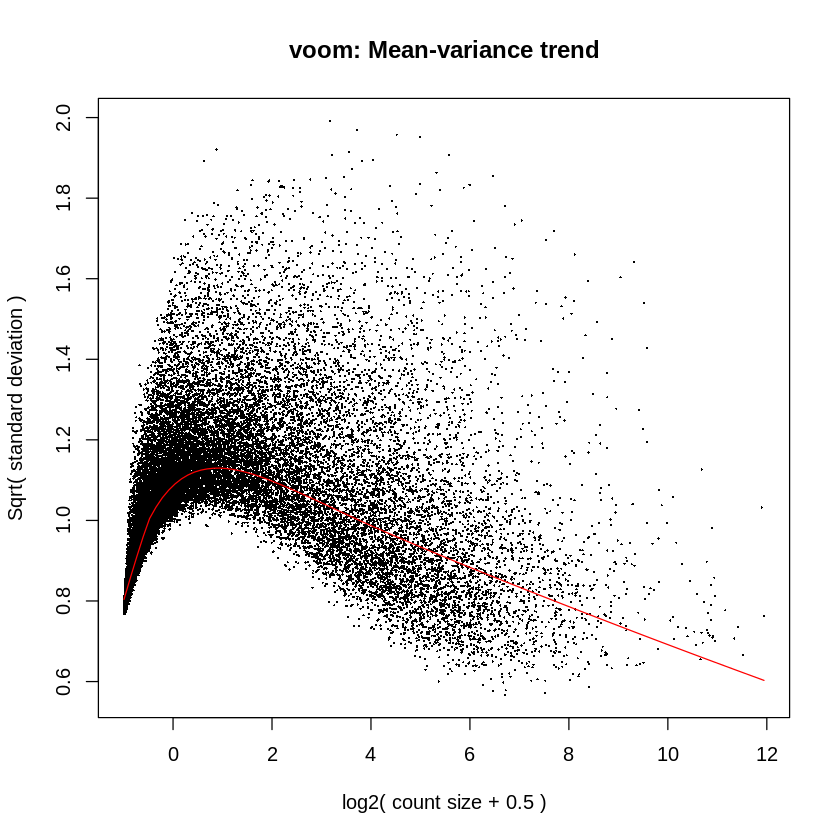

In [17]:
#     se
    splice_list       = c("a3ss_","a5ss_","mxe_","ri_","se_")
    tissue_list_m_f     = levels(reduced_metadata_pData$tissue)
    splice_index        = 5
    tissue_index        = 17
    plot                = TRUE
    splice_type         = splice_list    [splice_index] 
    tissue_of_interest  = tissue_list_m_f[tissue_index]
    fromGTF             = se_fromGTF_no_chrY
    metadata            = reduced_metadata_pData
    ijc                 = se_jc_ijc_no_chrY
    sjc                 = se_jc_sjc_no_chrY
    tissue_list         = tissue_list_m_f
    print_exploratory_plots (plot,
                         tissue_of_interest, 
                         splice_type, 
                         fromGTF, 
                         tissue_list_m_f, 
                         ijc, 
                         sjc, 
                         metadata)


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [ ]:
rm (notebookid)
notebookid   = "AllTissueJunctionAnalysis"
notebookid

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

### 2. Libraries metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]